In [1]:
import pandas as pd 
import numpy as np 
import random
import matplotlib.pyplot as plt 
import json
import folium
import networkx as nx

# 1. load data
The data file introduction is below:
1. **u.data**:   The full u data set, `100000 ratings` by `943 users` on `1682 items`. Each user has rated at least 20 movies.  Users and items are numbered consecutively from 1.  The data is randomly ordered. The time stamps are unix seconds since 1/1/1970 UTC.   

2. **u.item**: Information about the items (movies); The last `19 fields` are the genres, a 1 indicates the movie is of that genre, a 0 indicates it is not; movies can be in several genres at once. 

3. **u.genre**: A list of the genres.

4. **u.user**: Demographic information about the users

5. **u.occupation**: A list of the occupations.

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2021-05-24 06:59:15--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.9MB/s    in 0.3s    

2021-05-24 06:59:16 (16.9 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

# 2. Data analysis

## 2.1 Movie data

In [3]:
############################### Genre of the movies ############################### 
genre_data= pd.read_csv('ml-100k/u.genre',sep='|',names=["movie_type", "type_id"])
genre_data.head()

,movie_type,type_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [4]:
genre_cls = ["unknown", "Action", "Adventure", "Animation", \
              "Childrens", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", \
              "Sci-Fi", "Thriller", "War", "Western"]

In [5]:
############################### Information about the items (movies) ###############################
column_names = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", "unknown", "Action", "Adventure", "Animation", \
              "Childrens", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", \
              "Sci-Fi", "Thriller", "War", "Western"]
movies_data = pd.read_csv('ml-100k/u.item',sep='|', names=column_names,encoding = "ISO-8859-1")
movies_data['release_date'] = pd.to_datetime(movies_data['release_date'])
movies_data.rename(columns = {'movie_id':'item_id'}, inplace = True) 
movies_data

,item_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998-02-06,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),1998-02-06,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),1998-01-01,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Duplicated records
We found that there are movies that share exactly the same information but with different item_id (primary key). And there are exactly 18 movies that has such a duplication so in total 36 records that are not unique. We deal with these duplications later on, after checking if the original and the duplicate are both rated by users.

In [6]:
duplicated = movies_data[movies_data.duplicated('movie_title', False)].sort_values(by = 'movie_title')
duplicated.head()

,item_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
669,670,Body Snatchers (1993),1993-01-01,NaN,http://us.imdb.com/M/title-exact?Body%20Snatch...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
572,573,Body Snatchers (1993),1993-01-01,NaN,http://us.imdb.com/M/title-exact?Body%20Snatch...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
1649,1650,"Butcher Boy, The (1998)",1998-01-01,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1644,1645,"Butcher Boy, The (1998)",1998-01-01,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1233,1234,Chairman of the Board (1998),1998-01-01,NaN,http://us.imdb.com/Title?Chairman+of+the+Board...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### NaN record
We find that there is a record contains NaN for most of its attributes. However, we later on also found that there are users who did rate this item. So we decide not to drop this record.

In [7]:
movies_data[movies_data.release_date.isnull()]

,item_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaT,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
movies_data[movies_data.index == 266]

,item_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaT,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Year Cleaning
The movies lie in a span of 77 years.

In [9]:
l = sorted(movies_data.release_date.dt.year.unique().tolist())
max(l)  - min(l) + 1

77.0

#### Histogram of movies w.r.t. release year

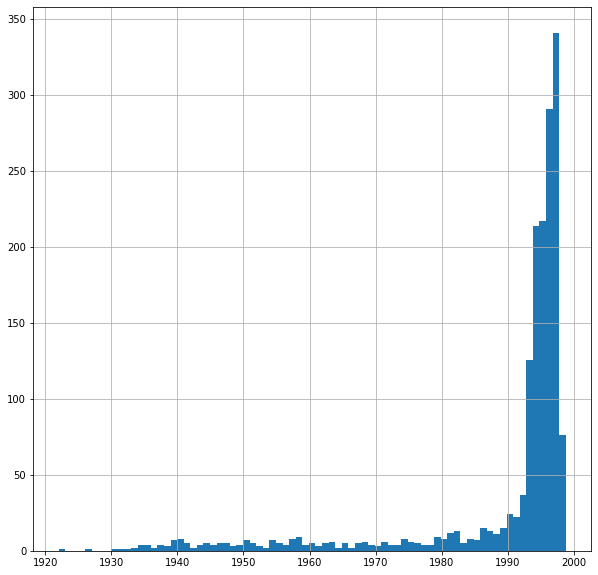

In [10]:
movies_data.release_date.hist(bins = 77, figsize = (10, 10))

Observing from the histogram showing the number of movies for each each, we notice that the movies mainly are released during 1990 and 1998. In order to facilitate the computation of similarity, we wish to aggregate years in which too few moives are released.

In [11]:
def compute_year_label(row):
    year = row['release_date'].year
    
    if year <= 1990 or np.isnan(year):
        return 1990
    else:
        return year

In [12]:
movies_data['year_label'] = movies_data.apply(lambda row: compute_year_label(row), axis = 1)

In [13]:
movies_data.year_label.unique()

array([1995, 1996, 1994, 1990, 1993, 1992, 1991, 1997, 1998])

### 2.1.1 statistical infos

#### Histogram of movies under each year label.

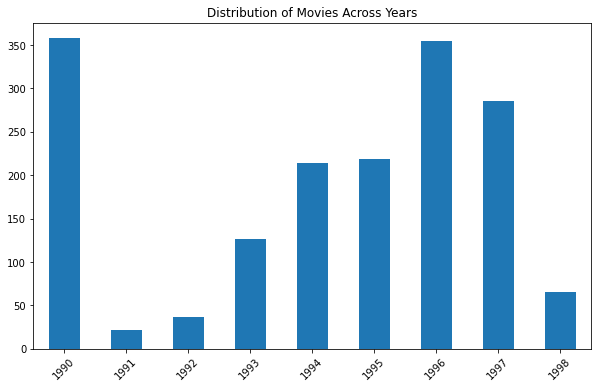

In [14]:
movies_data.year_label.value_counts().sort_index()\
.plot(kind = 'bar', rot = 45, figsize = (10, 6), title = 'Distribution of Movies Across Years')

#### The number of movies that falls in each genre.

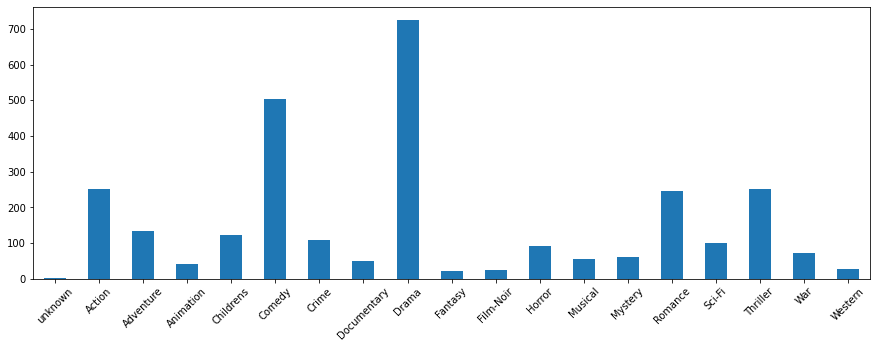

In [15]:
movies_data.sum()[movies_data.columns[5:-1]].plot(kind = 'bar', figsize = (15, 5), rot = 45)

Below we take a glimpse of the percentage of each genere's movies in each year.

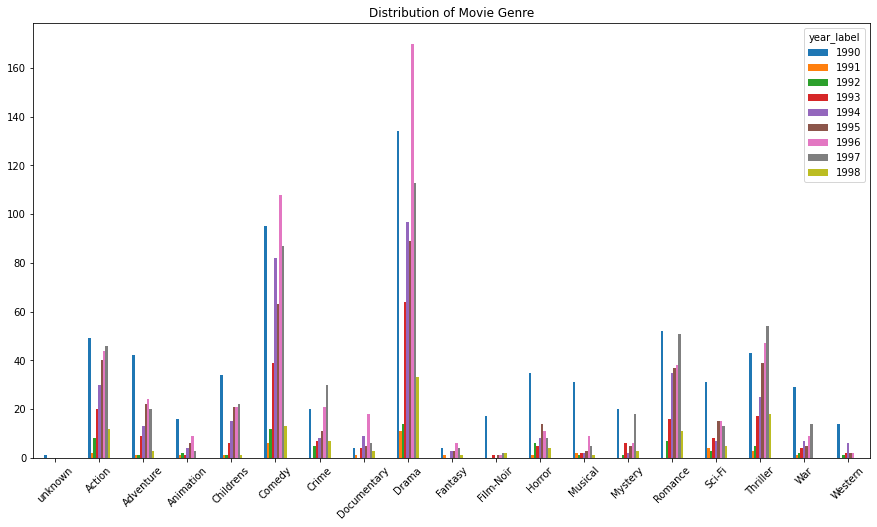

In [16]:
movies_data[movies_data.movie_title != 'unknown'].groupby('year_label').sum()[genre_cls].T\
        .plot(kind = 'bar', rot=45, figsize=(15,8), title = 'Distribution of Movie Genre')

Below we take a look at year 1995 - 1998 as an exmaple.

In [17]:
movie_1995 = movies_data[movies_data['release_date'].dt.year == 1995]
movie_1996 = movies_data[movies_data['release_date'].dt.year == 1996]
movie_1997 = movies_data[movies_data['release_date'].dt.year == 1997]
movie_1998 = movies_data[movies_data['release_date'].dt.year == 1998]

Text(0.5, 1.0, 'genres percentage over year')

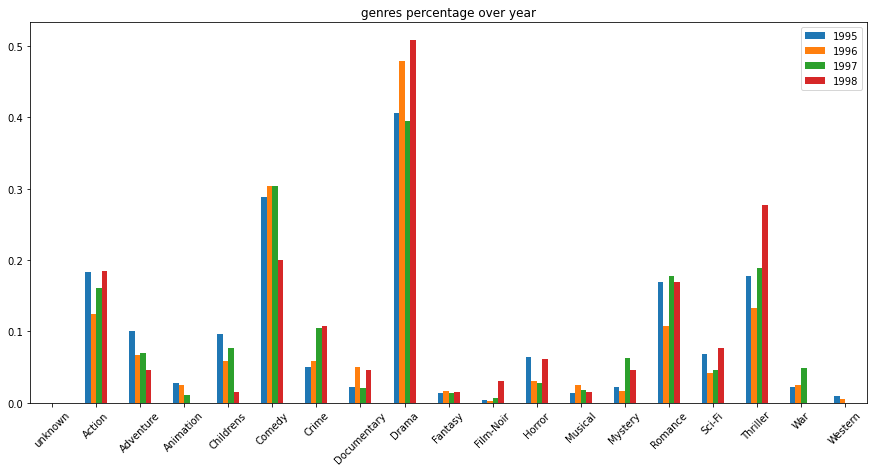

In [18]:
Year = {}
Year[1995] = movie_1995[genre_cls].sum()/len(movie_1995)
Year[1996] = movie_1996[genre_cls].sum()/len(movie_1996)
Year[1997] = movie_1997[genre_cls].sum()/len(movie_1997)
Year[1998] = movie_1998[genre_cls].sum()/len(movie_1998)
movie_year = pd.DataFrame(Year) 
axes = movie_year.plot.bar(rot=45,figsize=(15,7))
axes.set_title('genres percentage over year')

We conclude that the distribution of movie genres are generally balanced and hence are not biased.

## 2.2 user data

In [19]:
############################### Demographic information about the users ###############################
column_names = ["user_id", "age", "gender", "occupation", "zip_code"]
user_data = pd.read_csv('ml-100k/u.user',sep='|', names=column_names)
user_data

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [20]:
############################### A list of the occupations(the jobs types of users). ############################### 
occupation_data = pd.read_csv('ml-100k/u.occupation',sep='|',names=["occupation"])
occupation_data = occupation_data.reset_index().rename(columns={'index':'occupation_id'})

occupation_data.head()

,occupation_id,occupation
0,0,administrator
1,1,artist
2,2,doctor
3,3,educator
4,4,engineer


### 2.2.1 statistical info

#### Gender

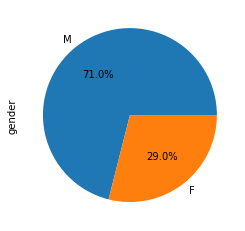

In [21]:
user_data['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')

#### Age

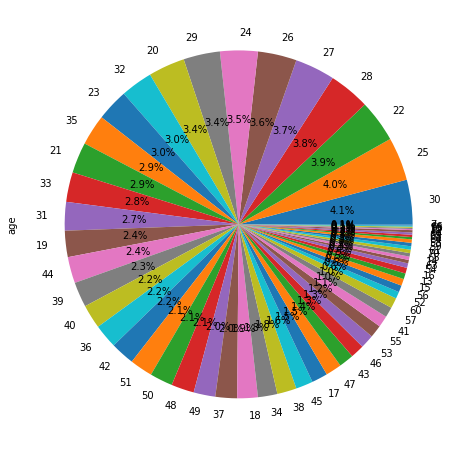

In [22]:
user_data['age'].value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(8,8))

#### Occupation

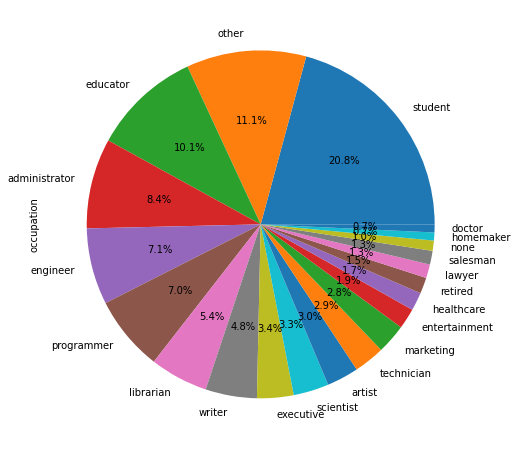

In [23]:
user_data['occupation'].value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(8,8))

### 2.2.2 location

We wish to find the geographical distribution of the users and to show them on a map. The only information we are given about this is the zip code and we find out there are only two countries involving these zip codes: America and Canada. And below we find out the number of users in Canada.

In [24]:
canada = 0
for i in range(len(user_data)):
    if user_data.loc[i].zip_code.isdigit() == False:
        canada += 1

canada

18

Geopy is used to find the exact coordinate corresponding to a zip code. And this information is stored in a dictionary.

In [26]:
geolocator.geocode?

In [27]:
code_table = {x: (0, 0) for x in user_data.zip_code.unique().tolist()}

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="liu")

for zip_code in code_table:
    if code_table[zip_code] != (0, 0):
        continue
    
    query_code = zip_code
    
    if query_code.isdigit() == False:
        continue

    # location = location = geolocator.geocode(query_code, country_codes = ['US'], timeout = 10)
    location = location = geolocator.geocode(query_code, timeout = 10)
    if not location:
        continue
    code_table[zip_code] = (location.latitude, location.longitude)

In [28]:
user_data['coordinate'] = user_data.apply(lambda row: code_table[row['zip_code']], axis = 1)

In [29]:
user_data.head()

,user_id,age,gender,occupation,zip_code,coordinate
0,1,24,M,technician,85711,"(47.85214441225751, 37.78990982662502)"
1,2,53,F,other,94043,"(37.40699294726802, -122.08883939781505)"
2,3,23,M,writer,32067,"(24.974616313832115, 121.25945677410526)"
3,4,24,M,technician,43537,"(41.57806694508656, -83.6802562611722)"
4,5,33,F,other,15213,"(40.44449552294444, -79.95342923046202)"


In [46]:
map2 = folium.Map(location=[38.9, -77.05], zoom_start=11)

from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(map2)


for i in range(0, len(user_data)):
    if user_data.loc[i].coordinate == (0, 0) or user_data.loc[i].zip_code.isdigit() == False:
        continue
    folium.Marker(user_data.iloc[i].coordinate, popup=str(user_data.loc[i].user_id), icon=folium.Icon(color='darkblue', icon_color='white', icon='male', angle=0, prefix='fa')).add_to(marker_cluster)

map2

Output hidden; open in https://colab.research.google.com to view.

## 2.3 Relational Info between Users and Movies

In [47]:
############################### Create user_item_matrix ############################### 
data= pd.read_csv('ml-100k/u.data',sep='\t', names=["user_id", "item_id", "rating", "timestamp"])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


Here we check for the duplicated items to see whether both of the two duplicated items are rated by users in this relational table.

In [48]:
data.merge(duplicated.item_id, on = 'item_id').item_id.nunique()

36

Because all the 36 items are reviewed by some users, so we conclude that the duplicated items have been both rated by users. Therefore, to remove the duplicates, we need to select one of the duplicated items as the main movie and direct all the ratings towards the other movie to this main one.

In [49]:
data.merge(duplicated.item_id, on = 'item_id')

,user_id,item_id,rating,timestamp
0,50,246,3,1997-10-17 01:38:49
1,269,246,5,1998-04-01 18:57:47
2,99,246,3,1998-02-26 05:03:12
3,276,246,4,1997-09-20 20:18:06
4,79,246,5,1998-03-30 15:25:45
...,...,...,...,...
1264,116,1256,1,1997-10-10 03:13:42
1265,463,1606,2,1998-03-15 04:36:05
1266,863,1680,2,1998-03-07 16:52:50
1267,587,1625,4,1998-04-18 03:55:32


Below we find the item id to be replaced and the item id that is going to be used.

In [50]:
duplicated_items = duplicated[['item_id', 'movie_title']].groupby('movie_title').apply(lambda x: list(x.item_id))
# remove_pattern = pd.DataFrame(duplicated_items.tolist(), index = duplicated_items.index, columns = ['item_id1', 'item_id2'])
to_replace = {}
for i, j in duplicated_items.values.tolist():
    to_replace[i] = j
to_replace

{246: 268,
 303: 297,
 305: 865,
 348: 329,
 500: 304,
 670: 573,
 680: 266,
 876: 881,
 1003: 878,
 1234: 1654,
 1257: 1256,
 1606: 309,
 1607: 1395,
 1617: 1175,
 1625: 1477,
 1650: 1645,
 1658: 711,
 1680: 1429}

Replace the duplicated item id with the replacement pattern shown above

In [51]:
data.replace({'item_id': to_replace}, inplace = True)

In [52]:
data.item_id.nunique()

1664

In [53]:
movies_data.item_id.nunique()

1682

We see that the 18 duplicated items are correctly replaced by its counterpart.

In [54]:
data_merged = pd.merge(data,user_data,on='user_id',how='left')
data_merged = pd.merge(data_merged,movies_data,on='item_id',how='left')
data_merged

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,coordinate,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year_label
0,196,242,3,1997-12-04 15:55:49,49,M,writer,55105,"(44.93591002353645, -93.15771479418866)",Kolya (1996),1997-01-24,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997
1,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,"(33.89116595631258, 35.50065238789327)",L.A. Confidential (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1997
2,22,377,1,1997-11-07 07:18:36,25,M,writer,40206,"(38.25743869638437, -85.70098484961258)",Heavyweights (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1994
3,244,51,2,1997-11-27 05:02:03,28,M,technician,80525,"(40.538784026809935, -105.06261961705628)",Legends of the Fall (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1994
4,166,346,1,1998-02-02 05:33:16,47,M,educator,55113,"(45.00672233376197, -93.16366429313092)",Jackie Brown (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,1997-11-22 05:10:44,13,M,student,83702,"(43.6295934590343, -116.20646011955073)","First Wives Club, The (1996)",1996-09-14,NaN,http://us.imdb.com/M/title-exact?First%20Wives...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996
99996,716,204,5,1997-11-17 19:39:03,36,F,administrator,44265,"(51.45788877765785, 7.490441698704062)",Back to the Future (1985),1985-01-01,NaN,http://us.imdb.com/M/title-exact?Back%20to%20t...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1990
99997,276,1090,1,1997-09-20 22:49:55,21,M,student,95064,"(36.99386818077129, -122.05960802079737)",Sliver (1993),1993-01-01,NaN,http://us.imdb.com/M/title-exact?Sliver%20(1993),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1993
99998,13,225,2,1997-12-17 22:52:36,47,M,educator,29206,"(34.02836172210214, -80.95817394724247)",101 Dalmatians (1996),1996-11-27,NaN,http://us.imdb.com/M/title-exact?101%20Dalmati...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996


We find that users only rated all these movies in 1997 and 1998.

In [ ]:
data_merged.timestamp.dt.year.unique()

#### top5 most rated movies for each year
Below we find the top 5 movies that are rated the most in each year and in total respectively.

In [56]:
data_1997 = data_merged[data_merged['timestamp'].dt.year == 1997]
data_1998 = data_merged[data_merged['timestamp'].dt.year == 1998]

In [57]:
data_1997.groupby('movie_title').count()[['item_id']].nlargest(5, columns = 'item_id').rename(columns={"item_id": 'count'})

,count
movie_title,
Star Wars (1977),335
Fargo (1996),301
Return of the Jedi (1983),300
Toy Story (1995),267
Liar Liar (1997),261


In [58]:
data_1998.groupby('movie_title').count()[['item_id']].nlargest(5, columns = 'item_id').rename(columns={"item_id": 'count'})

,count
movie_title,
Titanic (1997),322
Contact (1997),264
Star Wars (1977),248
Air Force One (1997),241
Scream (1996),238


In [59]:
data_merged.groupby('movie_title').count()[['item_id']].nlargest(5, columns = 'item_id').rename(columns={"item_id": 'count'})

,count
movie_title,
Star Wars (1977),583
Contact (1997),509
Fargo (1996),508
Return of the Jedi (1983),507
Liar Liar (1997),485


Text(0.5, 1.0, 'genres percentage over year')

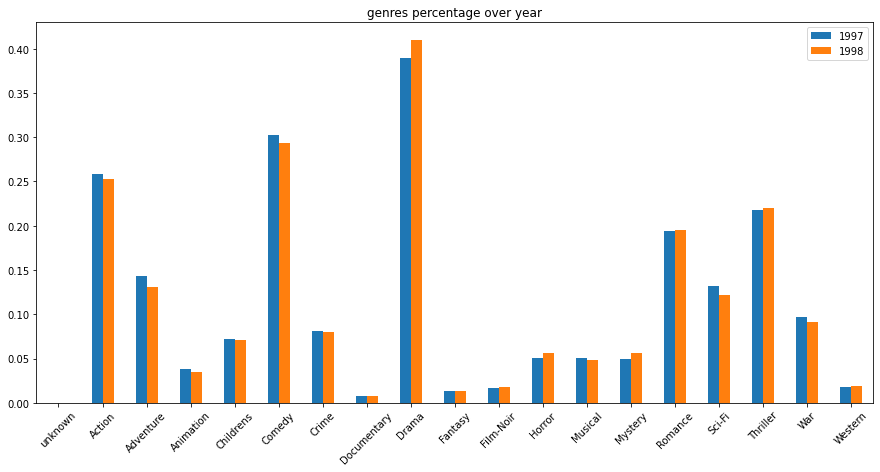

In [60]:
## the most rated movie genre every year
Popular = {}
Popular[1997] = data_1997[genre_cls].sum()/len(data_1997)
Popular[1998] = data_1998[genre_cls].sum()/len(data_1998)
Popular_year = pd.DataFrame(Popular) 
axes = Popular_year.plot.bar(rot=45,figsize=(15,7))
axes.set_title('genres percentage over year')

# 3. Graph analysis

## 3.1 user graph

In [61]:
def plt_graph(adjacency,data,title):
    graph_user = nx.from_numpy_matrix(adjacency)
    print('The number of connected components is {}'.format(nx.number_connected_components(graph_user)))
    coords = nx.spring_layout(graph_user,k=0.03)  # Force-directed layout.
    fig=plt.figure(figsize=(15, 10))
    labels = data.iloc[np.sort(nx.nodes(graph_user))]
    im=nx.draw_networkx_nodes(graph_user, coords, node_size=40,node_color=labels, cmap='tab20b',vmin=min(data), vmax=max(data))
    nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
    plt.title(title)
    plt.colorbar(im)
    return graph_user

In [62]:
# Initialize the adjacency matrix
n_users = len(user_data)
adjacency_user = np.zeros((n_users, n_users), dtype=float)
user_features1 =user_data.copy()[['user_id', 'age', 'gender', 'occupation', 'zip_code']]
user_features1['age_normal'] = user_features1['age']/max(user_features1['age'])
user_features1= pd.merge(user_features1,occupation_data,on='occupation',how='left')
user_features1['gender_id'] = user_features1['gender'].replace(['M','F'],[1,0])

In [63]:
user_features2=user_features1[['user_id','age','gender','occupation_id']].copy()
user_features2['avg_rating'] = data_merged[['user_id','item_id','rating']].groupby('user_id').mean()['rating'].values
user_features2['movie'] = data_merged[['user_id','item_id','rating']].groupby('user_id')['item_id'].apply(set).values

In [64]:
user_features1

,user_id,age,gender,occupation,zip_code,age_normal,occupation_id,gender_id
0,1,24,M,technician,85711,0.328767,19,1
1,2,53,F,other,94043,0.726027,13,0
2,3,23,M,writer,32067,0.315068,20,1
3,4,24,M,technician,43537,0.328767,19,1
4,5,33,F,other,15213,0.452055,13,0
...,...,...,...,...,...,...,...,...
938,939,26,F,student,33319,0.356164,18,0
939,940,32,M,administrator,02215,0.438356,0,1
940,941,20,M,student,97229,0.273973,18,1
941,942,48,F,librarian,78209,0.657534,10,0


In [65]:
user_features2

,user_id,age,gender,occupation_id,avg_rating,movie
0,1,24,M,19,3.610294,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2,53,F,13,3.709677,"{257, 258, 1, 10, 13, 14, 269, 272, 273, 274, ..."
2,3,23,M,20,2.796296,"{258, 260, 264, 268, 271, 272, 288, 294, 297, ..."
3,4,24,M,19,4.333333,"{258, 260, 264, 11, 271, 288, 294, 297, 300, 3..."
4,5,33,F,13,2.874286,"{1, 2, 17, 21, 24, 25, 29, 40, 42, 50, 62, 63,..."
...,...,...,...,...,...,...
938,939,26,F,18,4.265306,"{257, 258, 255, 1028, 9, 266, 15, 274, 275, 40..."
939,940,32,M,0,3.457944,"{4, 516, 7, 8, 9, 521, 12, 14, 527, 529, 549, ..."
940,941,20,M,18,4.045455,"{257, 258, 1, 7, 15, 273, 147, 919, 408, 294, ..."
941,942,48,F,10,4.265823,"{514, 1028, 520, 528, 1050, 539, 31, 50, 71, 5..."


### Metric 1: measure similarity between users by their age, gender, occupation and residence.

In [66]:
def similarity(row,data):
    sim = pd.DataFrame(np.cos(row['age_normal']-data['age_normal']))
    sim['gender'] = (row['gender']==data['gender'])
    sim['occupation'] = (row['occupation']==data['occupation'])
    sim['zip_code'] = (row['zip_code'] == data['zip_code'])
    return sim

In [67]:
for i in range(n_users):
    adjacency_user[i,:] = similarity(user_features1.loc[i,:],user_features1).mean(axis=1)

#### Adjacency Matrix of users

Text(0.5, 1.05, 'Adjacency matrix')

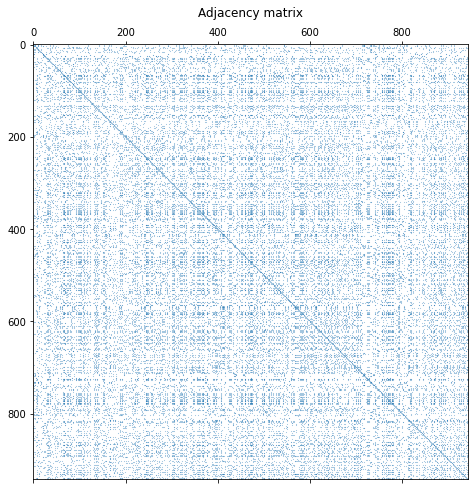

In [68]:
mask = adjacency_user<=0.5
adjacency = adjacency_user.copy()
adjacency[mask]=0

plt.figure(figsize=(8,8))
plt.spy(adjacency,markersize=0.1)
plt.title('Adjacency matrix')

#### User Graph 1 with colors representing gender

No specific pattern is identified from the distribution of the colours of the nodes.

The number of connected components is 12


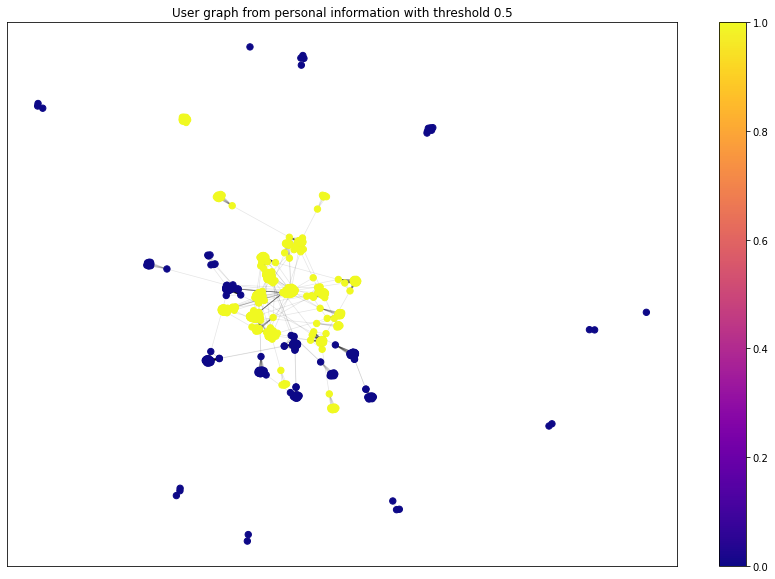

In [69]:
graph_user = nx.from_numpy_matrix(adjacency)
G = graph_user
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features1['gender_id'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='plasma',vmin=0, vmax=1)
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from personal information with threshold 0.5')
plt.colorbar(im)

#### User Graph 1 with colors representing Occupation

We do observe that there is nice and clear pattern here, as the nodes of the same colour falls in one cluster, meaning that people of the same occupation do share lots of similarities with repsect to movies of interest.

The number of connected components is 12


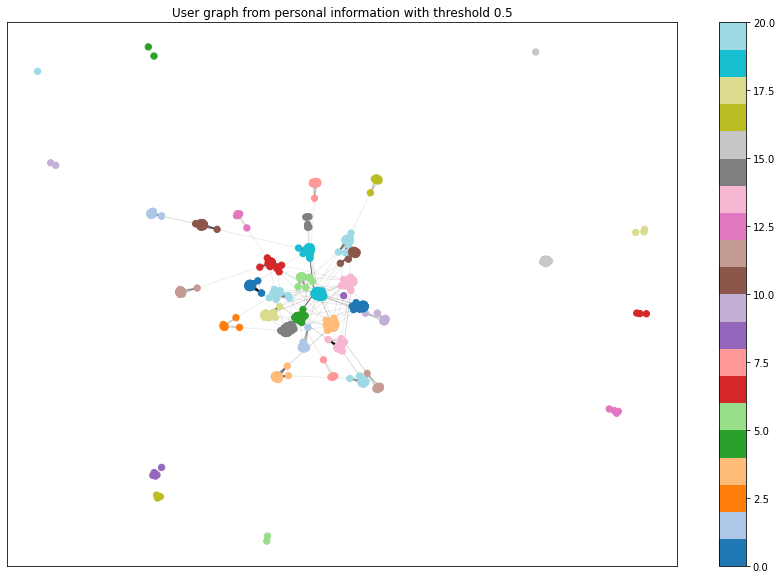

In [70]:
graph_user = nx.from_numpy_matrix(adjacency)
G = graph_user
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features1['occupation_id'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from personal information with threshold 0.5')
plt.colorbar(im)

#### User Graph 1 with colors representing Age
No specific pattern is identified from the distribution of the colours of the nodes.

The number of connected components is 12


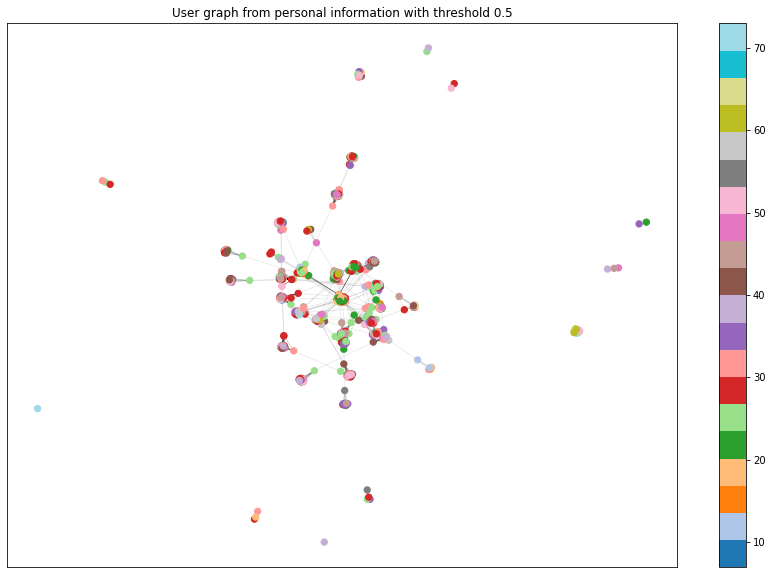

In [71]:
graph_user = nx.from_numpy_matrix(adjacency)
G = graph_user
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features1['age'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20',vmin=min(labels), vmax=max(labels))
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from personal information with threshold 0.5')
plt.colorbar(im)

#### Giant Components in User Graph 1

The number of nodes is is 903


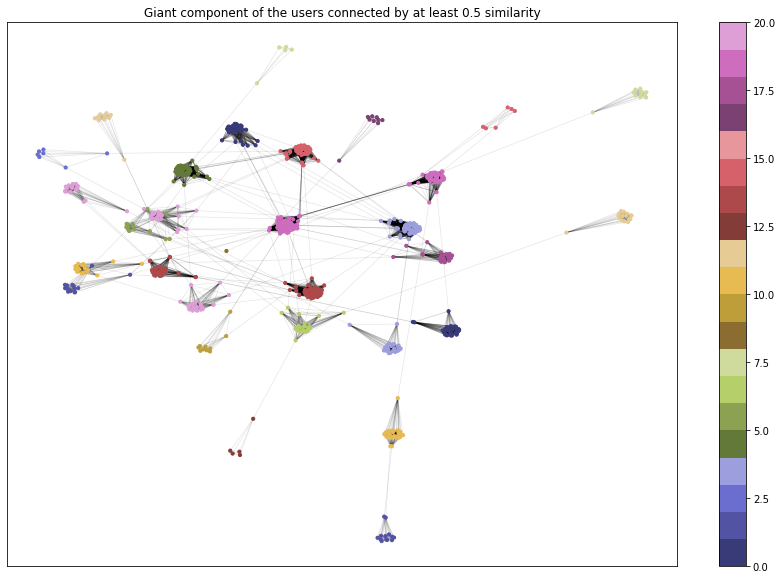

In [73]:
G = graph_user
Gc = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)
coords_Gc = nx.spring_layout(Gc,k=0.03)  # Force-directed layout.

print('The number of nodes is is {}'.format(Gc.number_of_nodes()))
labels = user_features1['occupation_id'].iloc[np.sort(nx.nodes(Gc))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=labels, cmap='tab20b',vmin=0, vmax=20)
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Giant component of the users connected by at least 0.5 similarity')
plt.colorbar(im);

#### Below we analyse the graph from the view of spectal theory

In [74]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    d = np.sum(adjacency, axis = 1)
    d_sqrt = np.sqrt(d)
    D = np.diag(1 / d_sqrt)
    if normalize:
        L = np.eye(adjacency.shape[0]) - (adjacency.T / d_sqrt).T / d_sqrt
    else:
        L = np.diag(d) - adjacency
    return L

def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    lamb, U = np.linalg.eigh(laplacian)
    
    return lamb, U

In [75]:
laplacian_norm = compute_laplacian(adjacency, normalize=True)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

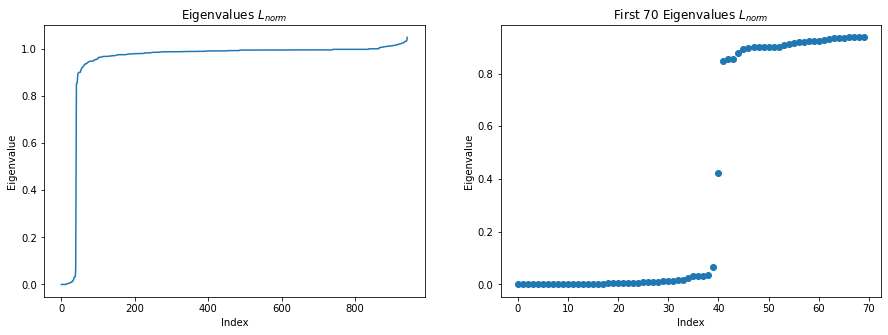

In [76]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')

plt.subplot(122)
first_k = 70
plt.scatter(range(first_k), lamb_norm[:first_k])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('First 70 Eigenvalues $L_{norm}$')

plt.show()

In order to observe the properties of the eigenvalues calculated, we zoom in the eigenvalues and we observe that there is a significant gap of eighvalues as shown in the plot, which correspond to the fact that there are about 40 clear clusters in the graph. As we know that if the data has exactly k clear clusters, there will be a gap in the Laplacian spectrum after the k-th eigenvalue. Here the clusters are generally defined by the occupation of the users. 

### Metric 2: meaure similarities between users by how many common movies they have rated

The more common movies two users have rated, the more similar they are.

In [77]:
# Calulate the number of common movies they have rated between two users
def common_movie(i,j,data):
    left = data[data['user_id']==i+1]['movie'].values.tolist()[0]
    right = data[data['user_id']==j+1]['movie'].values.tolist()[0]
    common = left.intersection(right)
    return len(common)

In [79]:
adjacency_user2 = np.zeros((n_users, n_users), dtype=float)
for i in range(n_users):
    for j in range(n_users):
        if j<i:
            adjacency_user2[i,j] = adjacency_user2[j,i]
        else:
            adjacency_user2[i,j] = common_movie(i,j,user_features2)
            
np.save('adjacency_user2.npy', adjacency_user2)

Histogram of the Median of common movies

Text(0.5, 1.0, 'histogram of number of common movies')

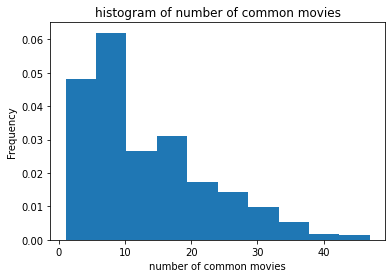

In [80]:
adjacency_user2 = np.load('adjacency_user2.npy')
median = []
for i in range(n_users):
    median.append(np.median(adjacency_user2[i,:]))

plt.hist(median, density=True)
plt.xlabel('number of common movies')
plt.ylabel('Frequency')
plt.title('histogram of number of common movies')

The adjacency matrix of **Metric 2**

Text(0.5, 1.05, 'Adjacency matrix')

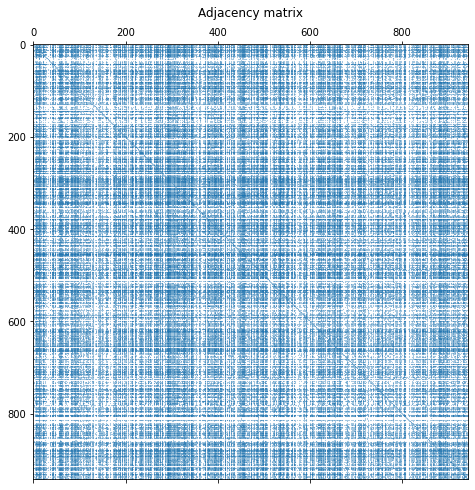

In [81]:
mask2 = adjacency_user2<20
adjacency = adjacency_user2.copy()
adjacency[mask2]=0

# Normalize 
adjacency_normalized = np.divide(adjacency,adjacency.max());
adjacency_normalized = adjacency
plt.figure(figsize=(8,8))
plt.spy(adjacency_normalized,markersize=0.1)
plt.title('Adjacency matrix')

#### User Graph 2 with colors representing Occupation

The number of connected components is 37


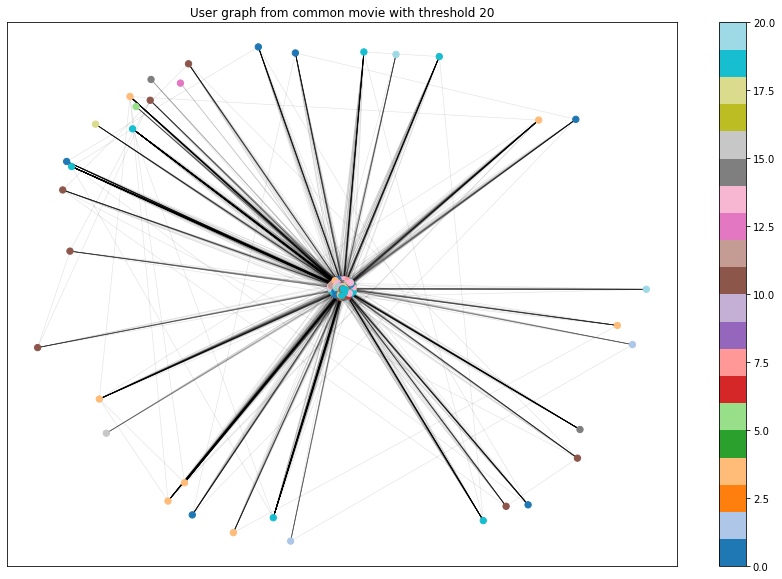

In [82]:
graph_user2 = nx.from_numpy_matrix(adjacency_normalized)
G = graph_user2
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features1['occupation_id'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

#### User Graph 2 with colors representing Average Rating

The number of connected components is 37


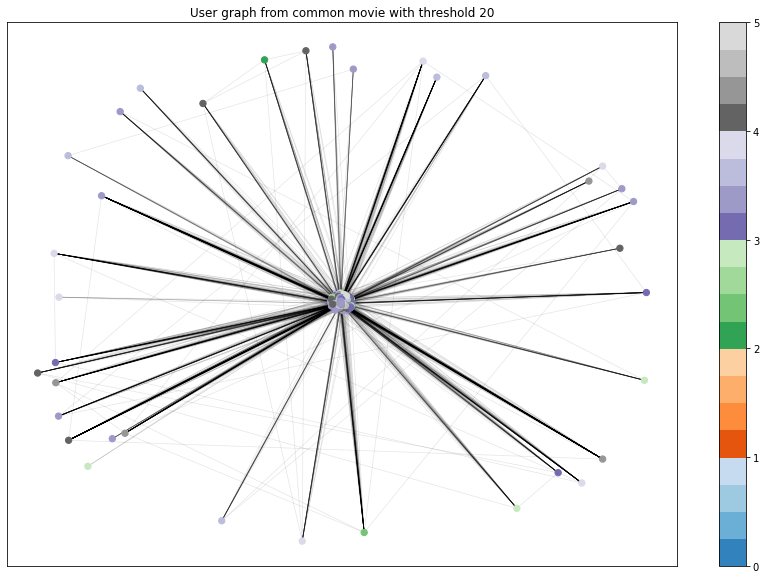

In [83]:
graph_user2 = nx.from_numpy_matrix(adjacency_normalized)
G = graph_user2
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features2['avg_rating'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20c',vmin=0, vmax=5)
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

#### User Graph 2 with colors representing Age of user

The number of connected components is 37


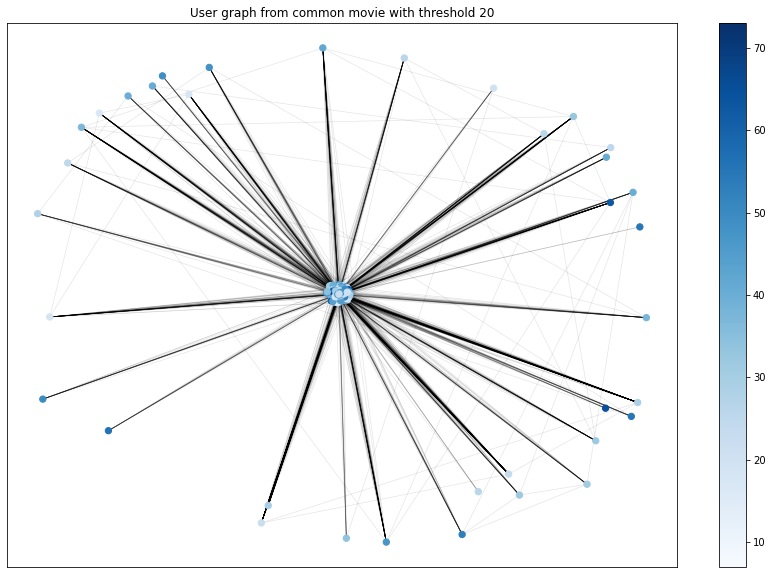

In [84]:
graph_user2 = nx.from_numpy_matrix(adjacency_normalized)
G = graph_user2
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features2['age'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='Blues',vmin=min(labels), vmax=max(labels))
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

#### Giant component of the User Graph 2 connected by at least 20 common movies

The number of nodes is is 907


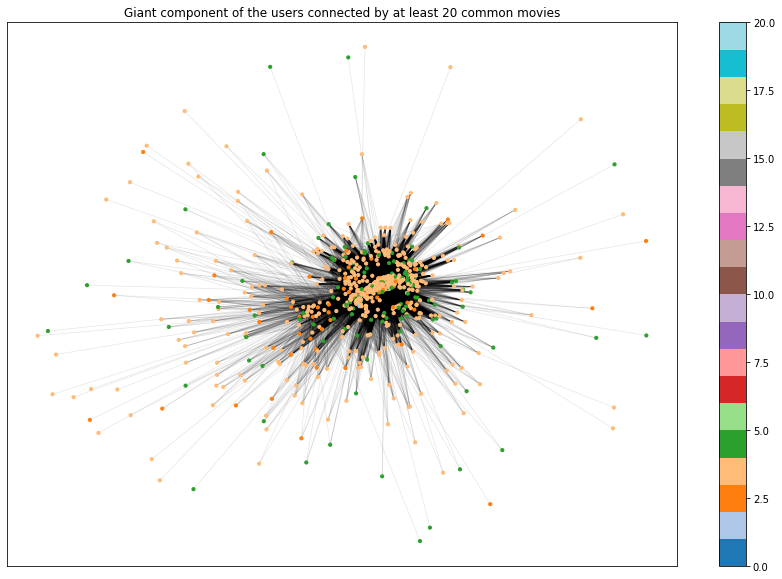

In [85]:
G = graph_user2
Gc = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)
coords_Gc = nx.spring_layout(Gc,k=0.03)  # Force-directed layout.
print('The number of nodes is is {}'.format(Gc.number_of_nodes()))
labels = user_features2['avg_rating'].iloc[np.sort(nx.nodes(Gc))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Giant component of the users connected by at least 20 common movies')
plt.colorbar(im);

In [86]:
laplacian_norm = compute_laplacian(adjacency_normalized, normalize=True)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


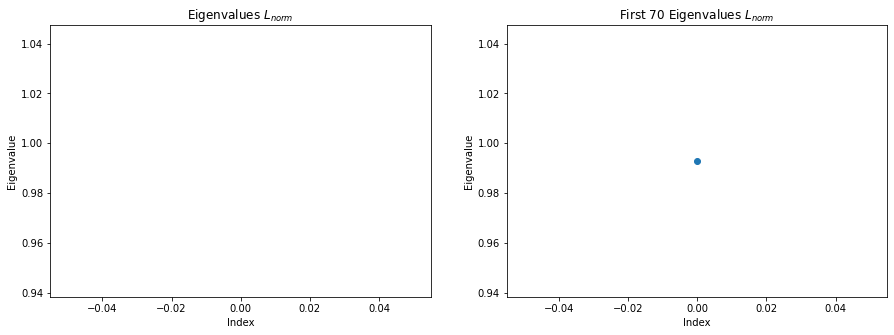

In [87]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')

plt.subplot(122)
first_k = 70
plt.scatter(range(first_k), lamb_norm[:first_k])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('First 70 Eigenvalues $L_{norm}$')

plt.show()

In order to observe the properties of the eigenvalues calculated, we zoom in the eigenvalues and we observe that there is a significant gap of eighvalues as shown in the plot, which correspond to the fact that there are about 35 clear clusters in the graph. As we know that if the data has exactly k clear clusters, there will be a gap in the Laplacian spectrum after the k-th eigenvalue. However, the pattern here in this user graph is not clear as most of them are not really clusters by outliers. There is only one giant component that dominates the graph.

## 3.2 movie graph

### Metric 1: similarity between moives measured by genres

In [92]:
movie_features1 = movies_data[['item_id']+genre_cls]
movie_features1.loc[:, 'year_label'] = movies_data['year_label']
movie_features1.reset_index(drop = True, inplace = True)
movie_features1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,item_id,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year_label
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1998
1678,1679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1998
1679,1680,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1998
1680,1681,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1994


In [93]:
# Initialize the adjacency matrix
n_movies = len(movie_features1)
adjacency_movie = np.zeros((n_movies, n_movies), dtype=float)

In [94]:
for i in range(n_movies):
    adjacency_movie[i,:] = np.logical_and(movie_features1.loc[i,:][genre_cls], movie_features1[genre_cls])\
    .sum(axis=1)

Text(0.5, 1.05, 'Adjacency matrix')

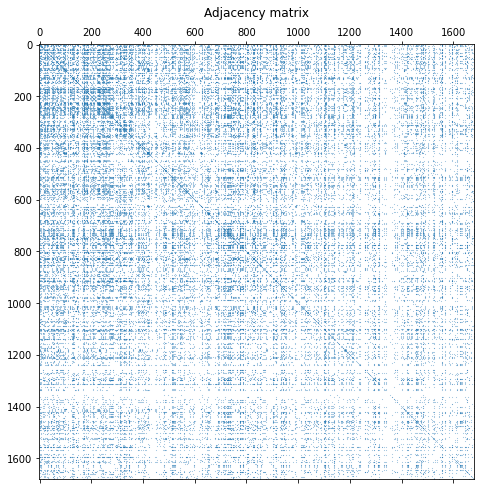

In [95]:
# Normalize 
mask_movie = adjacency_movie<2
adjacency = adjacency_movie.copy()
adjacency[mask_movie] = 0 
adjacency_movie_nor =np.divide(adjacency,adjacency.max())
plt.figure(figsize=(8,8))
plt.spy(adjacency_movie_nor,markersize=0.1)
plt.title('Adjacency matrix')